In [22]:
import os

import tensorflow as tf
from tensorflow.python.client import device_lib

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import numpy as np

In [23]:
print('TensorFlow version:', tf.__version__)
print('Is TensorFlow built with GPU support?', tf.test.is_built_with_cuda())

TensorFlow version: 2.10.0
Is TensorFlow built with GPU support? True


In [24]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print('Available GPUs:', gpus)
else:
    print('No GPUs found. Please check your GPU setup.')

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
for device in device_lib.list_local_devices():
    if device.device_type == 'GPU':
        print(device.physical_device_desc)
        break

device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [26]:
train_data_dir = r'E:\Projects\Wound-Classification-DL\data\train'
val_data_dir = r'E:\Projects\Wound-Classification-DL\data\val'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


In [27]:
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        GlobalAveragePooling2D(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model_path = r'E:\Projects\Wound-Classification-DL\models\best_cnn.h5'

if os.path.exists(model_path):
    print(f'Loading model')
    model = load_model(model_path)
else:
    print('No saved model found. Building a new model...')
    model = build_model()

model.summary()

No saved model found. Building a new model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 126, 126, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 61, 61, 64)       256       
 hNormalization)                                                 
        

In [28]:
checkpoint_callback = ModelCheckpoint(
    filepath=model_path,        
    monitor='val_accuracy',          
    save_best_only=True,             
    mode='max',                      
    verbose=0                       
)

early_stopping_callback = EarlyStopping(
    monitor='val_accuracy',         
    patience=10,                      
    mode='max',                     
    restore_best_weights=True,       
    verbose=1                        
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',       
    factor=0.5,               
    patience=3,               
    min_lr=1e-6,              
    verbose=1                 
)

history = model.fit(
    train_generator,
    epochs=3,
    verbose=1,
    validation_data=val_generator,
    callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr]
)

Epoch 1/3
250/250 [==============================] - 27s 106ms/step - loss: 2.8014 - accuracy: 0.3237 - val_loss: 4.3960 - val_accuracy: 0.1000 - lr: 0.0010
Epoch 2/3
250/250 [==============================] - 33s 133ms/step - loss: 2.0635 - accuracy: 0.4153 - val_loss: 2.8033 - val_accuracy: 0.1535 - lr: 0.0010
Epoch 3/3
250/250 [==============================] - 32s 130ms/step - loss: 1.7198 - accuracy: 0.4717 - val_loss: 1.8206 - val_accuracy: 0.4140 - lr: 0.0010


In [29]:
loss, accuracy = model.evaluate(val_generator)
print(f'Validation Loss: {loss:.4f}')
print(f'Validation Accuracy: {accuracy:.4f}')

63/63 [==============================] - 2s 27ms/step - loss: 1.8206 - accuracy: 0.4140
Validation Loss: 1.8206
Validation Accuracy: 0.4140


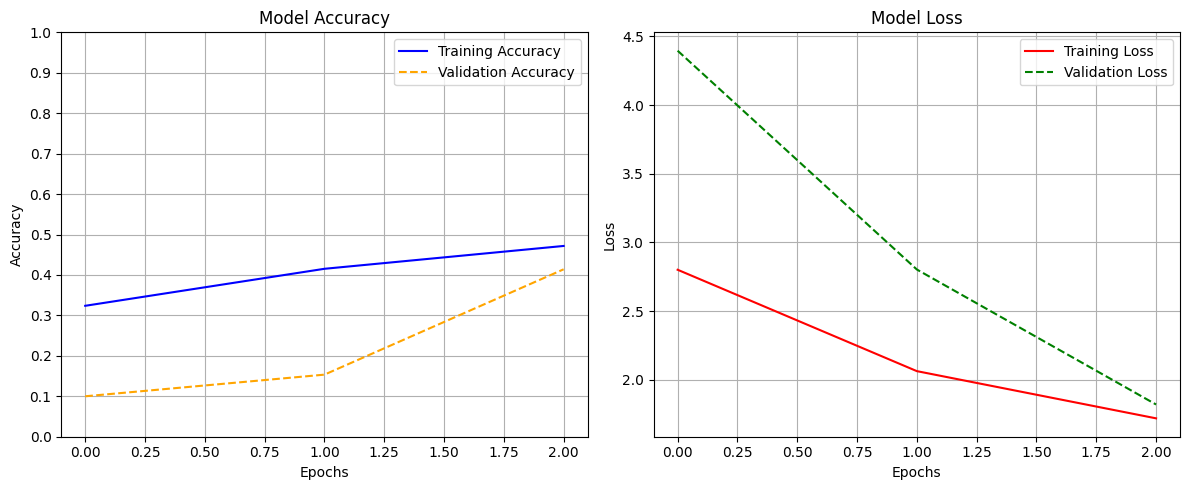

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue', linestyle='-')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange', linestyle='--')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].set_yticks(np.arange(0, 1.1, 0.1))
axes[0].legend()
axes[0].grid(True)

axes[1].plot(history.history['loss'], label='Training Loss', color='red', linestyle='-')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='green', linestyle='--')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()